In [1]:
import math
import os
import random
import yaml
import cv2
import numpy
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils import data

In [2]:
FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp'

class Dataset(data.Dataset):
    def __init__(self, filenames, input_size, params, augment):
        self.params = params
        self.mosaic = augment
        self.augment = augment
        self.input_size = input_size

        # Read labels
        cache = self.load_label(filenames)
        labels, shapes = zip(*cache.values())
        self.labels = list(labels)
        self.shapes = numpy.array(shapes, dtype=numpy.float64)
        self.filenames = list(cache.keys())  # update
        self.n = len(shapes)  # number of samples
        self.indices = range(self.n)
        # Albumentations (optional, only used if package is installed)
        self.albumentations = Albumentations()

    def __getitem__(self, index):
        index = self.indices[index]

        params = self.params
        mosaic = self.mosaic and random.random() < params['mosaic']

        if mosaic:
            shapes = None
            # Load MOSAIC
            image, label = self.load_mosaic(index, params)
            # MixUp augmentation
            if random.random() < params['mix_up']:
                index = random.choice(self.indices)
                mix_image1, mix_label1 = image, label
                mix_image2, mix_label2 = self.load_mosaic(index, params)

                image, label = mix_up(mix_image1, mix_label1, mix_image2, mix_label2)
        else:
            # Load image
            image, shape = self.load_image(index)
            h, w = image.shape[:2]

            # Resize
            image, ratio, pad = resize(image, self.input_size, self.augment)
            shapes = shape, ((h / shape[0], w / shape[1]), pad)  # for COCO mAP rescaling

            label = self.labels[index].copy()
            if label.size:
                label[:, 1:] = wh2xy(label[:, 1:], ratio[0] * w, ratio[1] * h, pad[0], pad[1])
            if self.augment:
                image, label = random_perspective(image, label, params)
        nl = len(label)  # number of labels
        if nl:
            label[:, 1:5] = xy2wh(label[:, 1:5], image.shape[1], image.shape[0])

        if self.augment:
            # Albumentations
            image, label = self.albumentations(image, label)
            nl = len(label)  # update after albumentations
            # HSV color-space
            augment_hsv(image, params)
            # Flip up-down
            if random.random() < params['flip_ud']:
                image = numpy.flipud(image)
                if nl:
                    label[:, 2] = 1 - label[:, 2]
            # Flip left-right
            if random.random() < params['flip_lr']:
                image = numpy.fliplr(image)
                if nl:
                    label[:, 1] = 1 - label[:, 1]

        target = torch.zeros((nl, 6))
        if nl:
            target[:, 1:] = torch.from_numpy(label)

        # Convert HWC to CHW, BGR to RGB
        sample = image.transpose((2, 0, 1))[::-1]
        sample = numpy.ascontiguousarray(sample)

        return torch.from_numpy(sample), target, shapes

    def __len__(self):
        return len(self.filenames)

    def load_image(self, i):
        image = cv2.imread(self.filenames[i])
        print(image.shape)
        h, w = image.shape[:2]
        r = self.input_size / max(h, w)
        if r != 1:
            image = cv2.resize(image,
                               dsize=(int(w * r), int(h * r)),
                               interpolation=resample() if self.augment else cv2.INTER_LINEAR)
        return image, (h, w)

    def load_mosaic(self, index, params):
        label4 = []
        image4 = numpy.full((self.input_size * 2, self.input_size * 2, 3), 0, dtype=numpy.uint8)
        y1a, y2a, x1a, x2a, y1b, y2b, x1b, x2b = (None, None, None, None, None, None, None, None)

        border = [-self.input_size // 2, -self.input_size // 2]

        xc = int(random.uniform(-border[0], 2 * self.input_size + border[1]))
        yc = int(random.uniform(-border[0], 2 * self.input_size + border[1]))

        indices = [index] + random.choices(self.indices, k=3)
        random.shuffle(indices)

        for i, index in enumerate(indices):
            # Load image
            image, _ = self.load_image(index)
            shape = image.shape
            if i == 0:  # top left
                x1a = max(xc - shape[1], 0)
                y1a = max(yc - shape[0], 0)
                x2a = xc
                y2a = yc
                x1b = shape[1] - (x2a - x1a)
                y1b = shape[0] - (y2a - y1a)
                x2b = shape[1]
                y2b = shape[0]
            if i == 1:  # top right
                x1a = xc
                y1a = max(yc - shape[0], 0)
                x2a = min(xc + shape[1], self.input_size * 2)
                y2a = yc
                x1b = 0
                y1b = shape[0] - (y2a - y1a)
                x2b = min(shape[1], x2a - x1a)
                y2b = shape[0]
            if i == 2:  # bottom left
                x1a = max(xc - shape[1], 0)
                y1a = yc
                x2a = xc
                y2a = min(self.input_size * 2, yc + shape[0])
                x1b = shape[1] - (x2a - x1a)
                y1b = 0
                x2b = shape[1]
                y2b = min(y2a - y1a, shape[0])
            if i == 3:  # bottom right
                x1a = xc
                y1a = yc
                x2a = min(xc + shape[1], self.input_size * 2)
                y2a = min(self.input_size * 2, yc + shape[0])
                x1b = 0
                y1b = 0
                x2b = min(shape[1], x2a - x1a)
                y2b = min(y2a - y1a, shape[0])

            image4[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            pad_w = x1a - x1b
            pad_h = y1a - y1b

            # Labels
            label = self.labels[index].copy()
            if len(label):
                label[:, 1:] = wh2xy(label[:, 1:], shape[1], shape[0], pad_w, pad_h)
            label4.append(label)

        # Concat/clip labels
        label4 = numpy.concatenate(label4, 0)
        for x in label4[:, 1:]:
            numpy.clip(x, 0, 2 * self.input_size, out=x)

        # Augment
        image4, label4 = random_perspective(image4, label4, params, border)

        return image4, label4

    @staticmethod
    def collate_fn(batch):
        samples, targets, shapes = zip(*batch)
        for i, item in enumerate(targets):
            item[:, 0] = i  # add target image index
        return torch.stack(samples, 0), torch.cat(targets, 0), shapes

    @staticmethod
    def load_label(filenames):
        path = f'{os.path.dirname(filenames[0])}.cache'
        if os.path.exists(path):
            return torch.load(path)
        x = {}
        for filename in filenames:
            try:
                # verify images
                with open(filename, 'rb') as f:
                    image = Image.open(f)
                    image.verify()  # PIL verify
                shape = image.size  # image size
                assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels'
                assert image.format.lower() in FORMATS, f'invalid image format {image.format}'

                # verify labels
                a = f'{os.sep}images{os.sep}'
                b = f'{os.sep}labels{os.sep}'
                if os.path.isfile(b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt'):
                    with open(b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt') as f:
                        label = [x.split() for x in f.read().strip().splitlines() if len(x)]
                        label = numpy.array(label, dtype=numpy.float32)
                    nl = len(label)
                    if nl:
                        assert label.shape[1] == 5, 'labels require 5 columns'
                        assert (label >= 0).all(), 'negative label values'
                        assert (label[:, 1:] <= 1).all(), 'non-normalized coordinates'
                        _, i = numpy.unique(label, axis=0, return_index=True)
                        if len(i) < nl:  # duplicate row check
                            label = label[i]  # remove duplicates
                    else:
                        label = numpy.zeros((0, 5), dtype=numpy.float32)
                else:
                    label = numpy.zeros((0, 5), dtype=numpy.float32)
                if filename:
                    x[filename] = [label, shape]
            except FileNotFoundError:
                pass
        torch.save(x, path)
        return x


def wh2xy(x, w=640, h=640, pad_w=0, pad_h=0):
    # Convert nx4 boxes
    # from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = numpy.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + pad_w  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + pad_h  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + pad_w  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + pad_h  # bottom right y
    return y


def xy2wh(x, w=640, h=640):
    # warning: inplace clip
    x[:, [0, 2]] = x[:, [0, 2]].clip(0, w - 1E-3)  # x1, x2
    x[:, [1, 3]] = x[:, [1, 3]].clip(0, h - 1E-3)  # y1, y2

    # Convert nx4 boxes
    # from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    y = numpy.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y


def resample():
    choices = (cv2.INTER_AREA,
               cv2.INTER_CUBIC,
               cv2.INTER_LINEAR,
               cv2.INTER_NEAREST,
               cv2.INTER_LANCZOS4)
    return random.choice(seq=choices)


def augment_hsv(image, params):
    # HSV color-space augmentation
    h = params['hsv_h']
    s = params['hsv_s']
    v = params['hsv_v']

    r = numpy.random.uniform(-1, 1, 3) * [h, s, v] + 1
    h, s, v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

    x = numpy.arange(0, 256, dtype=r.dtype)
    lut_h = ((x * r[0]) % 180).astype('uint8')
    lut_s = numpy.clip(x * r[1], 0, 255).astype('uint8')
    lut_v = numpy.clip(x * r[2], 0, 255).astype('uint8')

    im_hsv = cv2.merge((cv2.LUT(h, lut_h), cv2.LUT(s, lut_s), cv2.LUT(v, lut_v)))
    cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=image)  # no return needed


def resize(image, input_size, augment):
    # Resize and pad image while meeting stride-multiple constraints
    shape = image.shape[:2]  # current shape [height, width]

    # Scale ratio (new / old)
    r = min(input_size / shape[0], input_size / shape[1])
    if not augment:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    pad = int(round(shape[1] * r)), int(round(shape[0] * r))
    w = (input_size - pad[0]) / 2
    h = (input_size - pad[1]) / 2

    if shape[::-1] != pad:  # resize
        image = cv2.resize(image,
                           dsize=pad,
                           interpolation=resample() if augment else cv2.INTER_LINEAR)
    top, bottom = int(round(h - 0.1)), int(round(h + 0.1))
    left, right = int(round(w - 0.1)), int(round(w + 0.1))
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)  # add border
    return image, (r, r), (w, h)


def candidates(box1, box2):
    # box1(4,n), box2(4,n)
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    aspect_ratio = numpy.maximum(w2 / (h2 + 1e-16), h2 / (w2 + 1e-16))  # aspect ratio
    return (w2 > 2) & (h2 > 2) & (w2 * h2 / (w1 * h1 + 1e-16) > 0.1) & (aspect_ratio < 100)


def random_perspective(samples, targets, params, border=(0, 0)):
    h = samples.shape[0] + border[0] * 2
    w = samples.shape[1] + border[1] * 2

    # Center
    center = numpy.eye(3)
    center[0, 2] = -samples.shape[1] / 2  # x translation (pixels)
    center[1, 2] = -samples.shape[0] / 2  # y translation (pixels)

    # Perspective
    perspective = numpy.eye(3)

    # Rotation and Scale
    rotate = numpy.eye(3)
    a = random.uniform(-params['degrees'], params['degrees'])
    s = random.uniform(1 - params['scale'], 1 + params['scale'])
    rotate[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)

    # Shear
    shear = numpy.eye(3)
    shear[0, 1] = math.tan(random.uniform(-params['shear'], params['shear']) * math.pi / 180)
    shear[1, 0] = math.tan(random.uniform(-params['shear'], params['shear']) * math.pi / 180)

    # Translation
    translate = numpy.eye(3)
    translate[0, 2] = random.uniform(0.5 - params['translate'], 0.5 + params['translate']) * w
    translate[1, 2] = random.uniform(0.5 - params['translate'], 0.5 + params['translate']) * h

    # Combined rotation matrix, order of operations (right to left) is IMPORTANT
    matrix = translate @ shear @ rotate @ perspective @ center
    if (border[0] != 0) or (border[1] != 0) or (matrix != numpy.eye(3)).any():  # image changed
        samples = cv2.warpAffine(samples, matrix[:2], dsize=(w, h), borderValue=(0, 0, 0))

    # Transform label coordinates
    n = len(targets)
    if n:
        xy = numpy.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ matrix.T  # transform
        xy = xy[:, :2].reshape(n, 8)  # perspective rescale or affine

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        new = numpy.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # clip
        new[:, [0, 2]] = new[:, [0, 2]].clip(0, w)
        new[:, [1, 3]] = new[:, [1, 3]].clip(0, h)

        # filter candidates
        indices = candidates(box1=targets[:, 1:5].T * s, box2=new.T)
        targets = targets[indices]
        targets[:, 1:5] = new[indices]

    return samples, targets


def mix_up(image1, label1, image2, label2):
    # Applies MixUp augmentation https://arxiv.org/pdf/1710.09412.pdf
    alpha = numpy.random.beta(32.0, 32.0)  # mix-up ratio, alpha=beta=32.0
    image = (image1 * alpha + image2 * (1 - alpha)).astype(numpy.uint8)
    label = numpy.concatenate((label1, label2), 0)
    return image, label


class Albumentations:
    def __init__(self):
        self.transform = None
        try:
            import albumentations as album

            transforms = [album.Blur(p=0.01),
                          album.CLAHE(p=0.01),
                          album.ToGray(p=0.01),
                          album.MedianBlur(p=0.01)]
            self.transform = album.Compose(transforms,
                                           album.BboxParams('yolo', ['class_labels']))

        except ImportError:  # package not installed, skip
            pass

    def __call__(self, image, label):
        if self.transform:
            x = self.transform(image=image,
                               bboxes=label[:, 1:],
                               class_labels=label[:, 0])
            image = x['image']
            label = numpy.array([[c, *b] for c, b in zip(x['class_labels'], x['bboxes'])])
        return image, label

In [3]:
def load_label(filenames):
        path = f'{os.path.dirname(filenames[0])}.cache'
        if os.path.exists(path):
            return torch.load(path)
        x = {}
        for filename in filenames:
            try:
                # verify images
                with open(filename, 'rb') as f:
                    image = Image.open(f)
                    image.verify()  # PIL verify
                shape = image.size  # image size
                assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels'
                assert image.format.lower() in FORMATS, f'invalid image format {image.format}'

                # verify labels
                a = f'{os.sep}images{os.sep}'
                b = f'{os.sep}labels{os.sep}'
                label_path = b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt'
                print(f"Expected label path: {label_path}")  # Print expected label path
                
                if os.path.isfile(b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt'):
                    with open(b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt') as f:
                        label = [x.split() for x in f.read().strip().splitlines() if len(x)]
                        label = numpy.array(label, dtype=numpy.float32)
                    nl = len(label)
                    if nl:
                        assert label.shape[1] == 5, 'labels require 5 columns'
                        assert (label >= 0).all(), 'negative label values'
                        assert (label[:, 1:] <= 1).all(), 'non-normalized coordinates'
                        _, i = numpy.unique(label, axis=0, return_index=True)
                        if len(i) < nl:  # duplicate row check
                            label = label[i]  # remove duplicates
                    else:
                        label = numpy.zeros((0, 5), dtype=numpy.float32)
                    print(f"Processed labels for {filename}: \n{label}")  # Print the labels for the current file
                else:
                    label = numpy.zeros((0, 5), dtype=numpy.float32)
                    print(f"No label file found for {filename}. Expected at: {label_path}")  # Indicate that no label file was found for the current file
                if filename:
                    x[filename] = [label, shape]
            except FileNotFoundError:
                pass
        torch.save(x, path)
        return x

(768, 1024, 3)
1808
57855


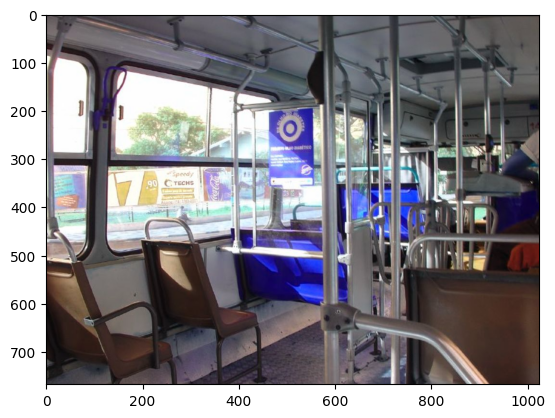

In [7]:
filenames = []
BATCH_SIZE = 32
with open('./utils/args_openimages.yaml', 'r') as f:
    params = yaml.safe_load(f)
    
with open('../data/train.txt') as reader:
    for filename in reader.readlines():
        filename = filename.rstrip().split('/')[-1]
        filenames.append('../data/new_data/train/' + filename)

image= cv2.imread(filenames[45])
print(image.shape)
img = plt.imshow(image)

dataset = Dataset(filenames, 640, params, True)


loader = data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)
print(len(loader))
print(len(filenames))
#train_features_batch, train_labels_batch = next(iter(loader))
#print(train_features_batch.shape, train_labels_batch.shape)


In [8]:
x = load_label(filenames)
x

{'../data/new_data/train/0000333f08ced1cd.jpg': [array([[62.      ,  0.502082,  0.51    ,  0.697752,  0.8825  ]],
        dtype=float32),
  (768, 1023)],
 '../data/new_data/train/00003e2837c7b728.jpg': [array([[54.      ,  0.661562,  0.797397,  0.463125,  0.230483]],
        dtype=float32),
  (1024, 689)],
 '../data/new_data/train/000060e3121c7305.jpg': [array([[1.27000e+02, 3.65625e-01, 6.49016e-01, 5.25000e-02, 2.34300e-02],
         [1.04000e+02, 4.53750e-01, 8.11153e-01, 1.70000e-01, 3.75820e-01],
         [1.53000e+02, 4.71875e-01, 8.10216e-01, 4.81250e-01, 3.21462e-01],
         [1.53000e+02, 8.14375e-01, 8.44423e-01, 3.70000e-01, 3.05529e-01],
         [1.28000e+02, 4.69375e-01, 5.79663e-01, 8.25000e-02, 7.77880e-02],
         [1.07000e+02, 1.46870e-02, 8.44423e-01, 2.93750e-02, 3.09279e-01],
         [1.07000e+02, 4.56875e-01, 7.89129e-01, 4.53750e-01, 2.47423e-01],
         [1.07000e+02, 8.09063e-01, 8.41612e-01, 3.80625e-01, 3.14902e-01],
         [1.47000e+02, 6.12500e-01, 7